#### Task 1.1: Data Understanding

Explore the incidents dataset using analytical tools and write a concise "data understanding" report that assesses data quality, the distribution of variables, and pairwise correlations.

#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

Subtasks of Data Understanding:

- Data semantics for each feature not described above and the new ones defined by the team
- Distribution of the variables and statistics
- Assessing data quality (missing values, outliers, duplicated records, errors)
- Variables transformations
- Pairwise correlations and eventual elimination of redundant variables

Nice visualization and insights can be obtained by exploiting the latitude and longitude features ([example](https://plotly.com/python/getting-started/)).

# Task 1.1:

We have to do some data understanding, so we're gonna explore the dataset. We can start with a simple analysis that establish the variable inside our dataset and visualize a bunch of their distibution, type, etc...

In [2]:
# This will take a while
!pip install seaborn
!pip install plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Dataset Structure

Let's breakdown the dataset :

- 28 Columns features: Some categorical like date, state etc... Others numerics: n_participants, n_males...
- At the end we've got some notes we could drop, these are not data we can easily manage with statistical tools

In [14]:
# Import the dataset

df_incidents = pd.read_csv('../source/ds/incidents.csv')

# Visualize data table

#df_incidents.columns
#df_incidents.dtypes

df_incidents.head()


/tmp/ipykernel_3851/3288230558.py:3: DtypeWarning:

Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,94.0,33.0,19.0,...,1.0,0.0,0,1,0.0,0.0,1.0,Teen wounded while walking - Security guard at...,Shot - Wounded/Injured,NaN
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,NaN,NaN,62.0,...,1.0,0.0,1,0,0.0,0.0,1.0,shot self after accident,"Shot - Dead (murder, accidental, suicide)",Suicide^
2,2016-11-05,Michigan,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,2.0,NaN,...,NaN,NaN,0,1,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN
4,2030-06-14,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,"Drive-by (car to street, car to car)"


In [15]:

# Example of unusable data

df_incidents['notes'].sample(10)
df_incidents['incident_characteristics1'].sample(10)


132377                                     Drug involvement
20532                             Shots Fired - No Injuries
152139            Shot - Dead (murder, accidental, suicide)
49812                             Shots Fired - No Injuries
95835             Shot - Dead (murder, accidental, suicide)
130206                                Non-Shooting Incident
131224    Shots fired, no action (reported, no evidence ...
140507                               Shot - Wounded/Injured
118756                            Shots Fired - No Injuries
199520                               Shot - Wounded/Injured
Name: incident_characteristics1, dtype: object

# Data Cleaning

- [x] Remove NaNs
- [x] Remove Duplicates
- [ ] Remove columns with a lot of NaNs [Note this has to be done before removing NaNs]
- [ ] Outliers
- [ ] Remove Unnecessary data for statistical analysis
    

In [25]:
# Remove NaNs

# How do we define if a columns has a lot of nans?
df_incidents.isna().sum()

#   Let's get the % of nans with respect to the total number of records, if is > 50% we drop the column

for col in df_incidents.columns:
    pct_missing = np.mean(df_incidents[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

    # drop if more than 50% of the data is missing
    if pct_missing > 0.5:
        df_incidents.drop(col, axis=1, inplace=True)


#df_incidents.shape

# Finally deleting all NaNs
df_incidents_nona = df_incidents.dropna()

date - 0%
state - 0%
city_or_county - 0%
address - 7%
latitude - 3%
longitude - 3%
congressional_district - 5%
state_house_district - 16%
state_senate_district - 13%
participant_age1 - 39%
participant_age_group1 - 18%
participant_gender1 - 15%
min_age_participants - 31%
avg_age_participants - 31%
max_age_participants - 31%
n_participants_child - 18%
n_participants_teen - 18%
n_participants_adult - 18%
n_males - 15%
n_females - 15%
n_killed - 0%
n_injured - 0%
n_arrested - 12%
n_unharmed - 12%
n_participants - 0%
notes - 34%
incident_characteristics1 - 0%
incident_characteristics2 - 41%


In [26]:
# Remove Duplicates

df_incidents_nodup = df_incidents_nona.drop_duplicates()


## Mass Shooting

As we can see sometimes the number of people killed or injured it's not an incident it's a mass shooting

Let's remove this by taking into account this definition

```
    FBI Definition: The Federal Bureau of Investigation (FBI) defines a mass shooting as an incident in which four or more people, not including the shooter, are killed. This definition is often used in the United States.
```

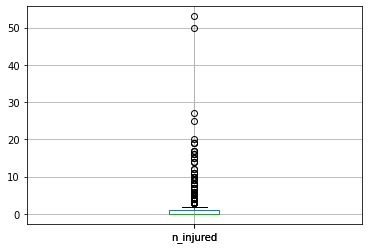

In [31]:
# Let's visualize outliers with a boxplot

df_incidents_nodup.boxplot(column='n_killed')
df_incidents_nodup.boxplot(column='n_injured')

# Remove outliers if n_killed or n_injured > 4
df_incident_no_outliers = df_incidents_nodup[(df_incidents_nodup['n_killed'] < 4) & (df_incidents_nodup['n_injured'] < 4)]

<AxesSubplot:>

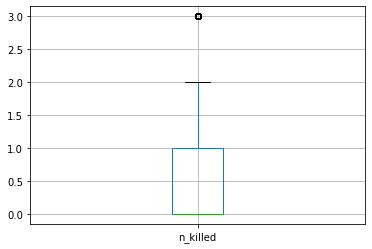

In [30]:
df_incident_no_outliers.boxplot(column='n_killed')

## Visualize Distributions

From the first we can see that plotting distirbution of n_killed against the number of incidents we can see that in the majority of the incidents people do not die. 

We have a distribution skewed to the left so the asimmetry index must be positive.

n_killed
0    69.318337
1    26.495226
2     3.614317
3     0.572120
dtype: float64


 Skewness of n_killed: 1.582712


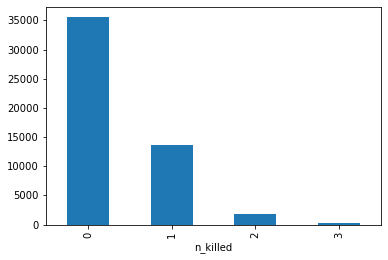

In [71]:
# Using seaborn to visualize the distribution of n_killed 

# In %
print((df_incident_no_outliers.groupby('n_killed').size()/len(df_incident_no_outliers)*100))

df_incident_no_outliers['n_killed'].value_counts().plot(kind='bar')

# PIE CHARTs ARE ILLEGAL
#df_incident_no_outliers['n_killed'].value_counts().plot(kind='pie')

# Asimmetry index is pos
skewness_n_killed = df_incident_no_outliers['n_killed'].skew()
print('\n\n',"Skewness of n_killed: %f" % skewness_n_killed)